<a href="https://colab.research.google.com/github/anupj/PyTorchForDeepLearningBootcamp/blob/main/04_pytorch_custom_datasets_video.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 04. PyTorch Custom Datasets Video Notebook

We've used some datasets with PyTorch before, but how do you get your own data into PyTorch?

One of the ways to do so is via: **custom datasets**.

## Domain libraries
PyTorch has both existing data loading functions and customisable data loading functions for [domains](https://pytorch.org/pytorch-domains) like vision, text, audio, recommendations etc.
e.g. [torchvision](https://pytorch.org/vision/stable/index.html), [torchdata - beta](https://pytorch.org/data/beta/index.html)

**Resources**
* Course Materials: https://www.learnpytorch.io/04_pytorch_custom_datasets/

## 0. Importing PyTorch and setting up device-agnostic code

In [19]:
import torch
from torch import nn

torch.__version__

'2.5.1+cu121'

In [20]:
# Setup device-agnostic code
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [21]:
!nvidia-smi

Tue Nov 26 06:01:48 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   37C    P8               9W /  70W |      3MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

## 1. Get data

Our dataset is a subset of the [Food101 dataset](https://pytorch.org/vision/main/generated/torchvision.datasets.Food101.html)
>The Food-101 is a challenging data set of 101 food categories with 101,000 images. For each class, 250 manually reviewed test images are provided as well as 750 training images. On purpose, the training images were not cleaned, and thus still contain some amount of noise. This comes mostly in the form of intense colors and sometimes wrong labels. All images were rescaled to have a maximum side length of 512 pixels.

Our *mini* dataset contains 3 classes of food and only 10% of the images, so about ~75 training, and ~25 testing data points.

**Why?**
When starting out ML projects, it's important to try things on a small scale and then increase the scale when necessary.
This will speed up experimentation cycles.

In [22]:
import requests
import zipfile
from pathlib import Path

# Setup a path to a data folder
data_path = Path("data/")
image_path = data_path / "pizza_steak_sushi"

# Check if image folder exists
if image_path.is_dir():
  print(f"{image_path} directory already exists...skipping downloading")
else:
  # create the image folder
  print(f"{image_path} does not exist, creating one...")
  image_path.mkdir(parents=True, exist_ok=True)
  # Download images data
  with open(data_path / "pizza_steak_sushi.zip", "wb") as f:
    request = requests.get(url="https://github.com/mrdbourke/pytorch-deep-learning/raw/refs/heads/main/data/pizza_steak_sushi.zip")
    print("Downloading pizza, steak, sushi data")
    f.write(request.content)
  # Unzip pizza, steak, sushi data
  with zipfile.ZipFile(data_path / "pizza_steak_sushi.zip", "r") as zip_ref:
    print("Unzipping pizza, steak, and sushi data...")
    zip_ref.extractall(image_path)

data/pizza_steak_sushi directory already exists...skipping downloading


## 2. Becoming one with the data (data prep and data exploration)

In [23]:
import os

def walk_through_dir(dir_path: Path) -> None:
  """Walks through a directory and its subdirectories, printing the number of subdirectories and files found at each level.

  This function is useful for exploring the structure and contents of a directory especially when working with directories. It provides a summary of the directory hierarchy and the number of files within each directory.

  Args:
    dir_path (str or pathlib.Path): The path to the directory you to explore.
  Returns:
    None: This function prints information to the console but does not return any values.

  Example:
    >>> walk_through_dir("data/my_dataset")
    There are 2 directories and 10 images in 'data/my_dataset'
    There are 0 directories and 5 images in 'data/my_dataset/train'
    There are 0 directories and 5 images in 'data/my_dataset/test'
  """
  for dirpath, dirnames, filenames in os.walk(dir_path):
    print(f"There are {len(dirnames)} directories and {len(filenames)} images in '{dirpath}'")

In [24]:
walk_through_dir(dir_path=image_path)

There are 2 directories and 0 images in 'data/pizza_steak_sushi'
There are 3 directories and 0 images in 'data/pizza_steak_sushi/train'
There are 0 directories and 78 images in 'data/pizza_steak_sushi/train/pizza'
There are 0 directories and 72 images in 'data/pizza_steak_sushi/train/sushi'
There are 0 directories and 75 images in 'data/pizza_steak_sushi/train/steak'
There are 3 directories and 0 images in 'data/pizza_steak_sushi/test'
There are 0 directories and 25 images in 'data/pizza_steak_sushi/test/pizza'
There are 0 directories and 31 images in 'data/pizza_steak_sushi/test/sushi'
There are 0 directories and 19 images in 'data/pizza_steak_sushi/test/steak'


In [25]:
# Setup train and training paths
train_dir = image_path / "train"
test_dir = image_path / "test"

print(f"Training directory path is '{train_dir}'")
print(f"Testing directory path is '{test_dir}'")

Training directory path is 'data/pizza_steak_sushi/train'
Testing directory path is 'data/pizza_steak_sushi/test'


### 2.1 Visualising images

Let's write some code to:
1. Get all of the image paths
2. Pick a *random* image path using Python's `random.choice()`
3. Get the image class name using `pathlib.Path.parent.stem`
4. Since we're working with _images_, let's open the image with Python's PIL (or rather the `Pillow` fork of `PIL` library)
5. Show the image and print metadata

Random image path: data/pizza_steak_sushi/test/sushi/887831.jpg
Random image class: sushi
Random image height: 512
Random image width: 512
img type is: <class 'PIL.JpegImagePlugin.JpegImageFile'>


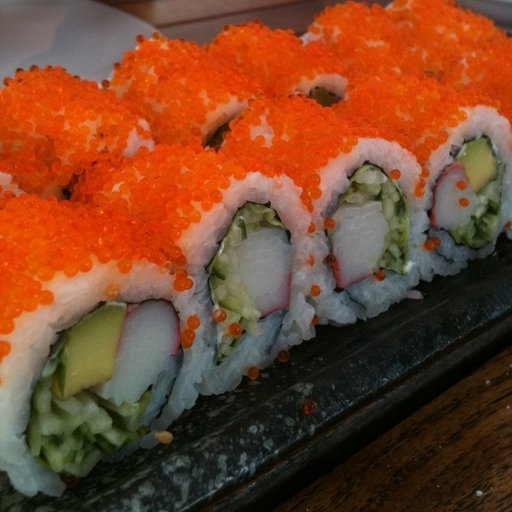

In [26]:
import random
from PIL import Image # NTS - where's Pillow fork?

# set seed
# random.seed(42)

# 1. Get all image paths
image_path_list = list(image_path.glob("*/*/*.jpg"))

# 2. Pick a random image path
random_image_path = random.choice(image_path_list)

# 3. Get image class from path name
# `image_class` is the name of the
# directory where the image is stored
image_class = random_image_path.parent.stem

# 4. Open image using PIL
img = Image.open(random_image_path)

# 5. Print metadata
print(f"Random image path: {random_image_path}")
print(f"Random image class: {image_class}")
print(f"Random image height: {img.height}")
print(f"Random image width: {img.width}")
print(f"img type is: {type(img)}")
img


(-0.5, 511.5, 511.5, -0.5)

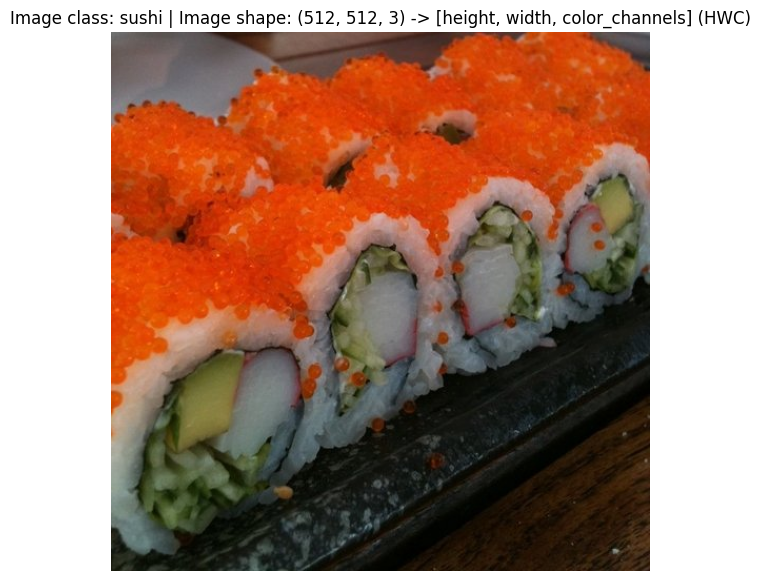

In [27]:
# Visualize the image using matplotlib

import numpy as np
import matplotlib.pyplot as plt

# Turn the image into an array
img_as_array = np.asarray(img)
# img_as_array

# Plot the image with matplotlib
plt.figure(figsize=(10,7))
plt.imshow(img_as_array)
plt.title(f"Image class: {image_class} | Image shape: {img_as_array.shape} -> [height, width, color_channels] (HWC)")
plt.axis(False)

## 3. Transforming data

Before we can use our image data with Pytorch:
1. Turn your target data into tensors
  - in our case, it will be numerical representation of our images
2. Turn it into a `torch.utils.data.Dataset` and subsequently a `torch.utils.data`

In [28]:
import torch
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

### 3.1 Transforming data with `torchvision.transforms`

Transforms help you get your images ready to be used with a model and perform data augmentation - https://pytorch.org/vision/stable/transforms.html

In [29]:

# Write a transform for image
data_transform = transforms.Compose([
    # Resize our images to 64x64 from about 512x512
    transforms.Resize(size=(64,64)),
    # Flip the images randomly on the horizontal
    transforms.RandomHorizontalFlip(p=0.5),
    # Turn the image from a PIL image to a torch.Tensor
    transforms.ToTensor()
])


In [30]:
data_transform(img)

tensor([[[0.4196, 0.4157, 0.4078,  ..., 0.3451, 0.3451, 0.3451],
         [0.4157, 0.4196, 0.4118,  ..., 0.3412, 0.3451, 0.3373],
         [0.4000, 0.4078, 0.4196,  ..., 0.4627, 0.2941, 0.2784],
         ...,
         [0.1137, 0.1137, 0.2431,  ..., 0.2510, 0.2784, 0.2627],
         [0.1373, 0.1451, 0.1333,  ..., 0.2353, 0.2314, 0.2157],
         [0.1255, 0.1451, 0.1294,  ..., 0.2588, 0.2235, 0.2235]],

        [[0.4157, 0.4000, 0.3843,  ..., 0.3255, 0.3294, 0.3412],
         [0.3882, 0.3843, 0.3725,  ..., 0.3098, 0.3216, 0.3255],
         [0.3608, 0.3647, 0.3686,  ..., 0.2588, 0.2392, 0.2549],
         ...,
         [0.1294, 0.1412, 0.2941,  ..., 0.1686, 0.1804, 0.1686],
         [0.1529, 0.1686, 0.1569,  ..., 0.1529, 0.1490, 0.1412],
         [0.1412, 0.1686, 0.1529,  ..., 0.1608, 0.1451, 0.1490]],

        [[0.4118, 0.4000, 0.3765,  ..., 0.3412, 0.3451, 0.3608],
         [0.3765, 0.3765, 0.3647,  ..., 0.3176, 0.3373, 0.3451],
         [0.3412, 0.3569, 0.3569,  ..., 0.1922, 0.2431, 0.

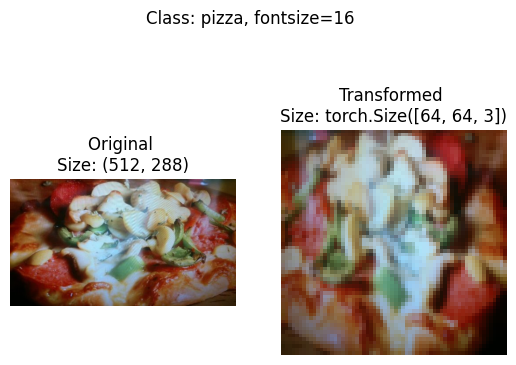

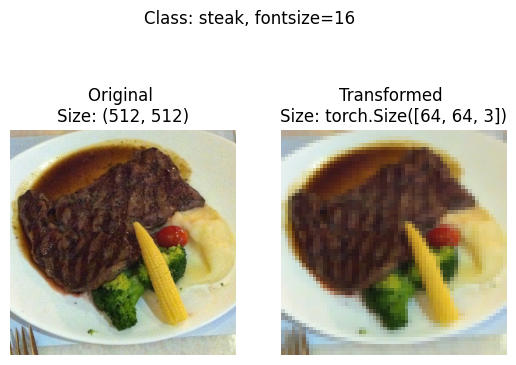

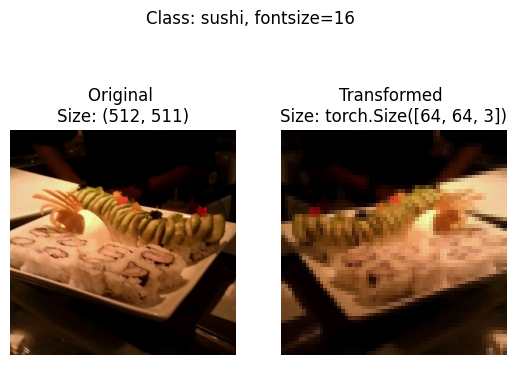

In [31]:
def plot_tranformed_images(image_paths,
                           transform,
                           n=3,
                           seed=None):
  """Plots a series of random images from `image_paths`.
  Will open `n` image paths from `image_paths`, transform them with
  `data_transform` and plot them side by side.

  Args:
    image_paths(list): List of target image paths
    transform(PyTorch Transforms): Transforms to apply to images.
    n (int, optional): Number of images to plot. Defaults to 3.
    seed (int, optional): Random seed for the random generator. Defaults to `42`
  """
  if seed:
    random.seed(seed)
  random_image_paths = random.sample(image_paths, k=n)
  for image_path in random_image_paths:
    with Image.open(image_path) as f:
      fig, ax = plt.subplots(1, 2)
      ax[0].imshow(f)
      ax[0].set_title(f"Original \nSize: {f.size}")
      ax[0].axis("off")

      # Transform and plot image
      # Note: `permute()` will change shape of image to suit matplotlib
      # (PyTorch default is [C, H, W] but Matplotlib is [H, W, C])
      transformed_image = transform(f).permute(1, 2, 0)
      ax[1].imshow(transformed_image)
      ax[1].set_title(f"Transformed \nSize: {transformed_image.shape}")
      ax[1].axis("off")

      fig.suptitle(f"Class: {image_path.parent.stem}, fontsize=16")

plot_tranformed_images(image_path_list,
                       transform=data_transform,
                       n=3)

## 4. Option 1: Loading image data using `ImageFolder`

Alright, time to turn our images into a `Dataset` capable of being used with PyTorch.

Since our data is in standard image classification format, we can use the class `torchvision.datasets.ImageFolder`, where we can pass it the file path of a target image directory as well as a series of transforms we'd like to perform on our images.

Let's test it out on our data folders train_dir and test_dir passing in transform=data_transform to turn our images into tensors.

In [32]:
# Use ImageFolder to create dataset(s)
from torchvision import datasets
train_data = datasets.ImageFolder(root=train_dir, # target folder of images
                                  transform=data_transform, # transforms to perform on data (images)
                                  target_transform=None #transforms to perform on labels (if necessary)
                                  )

test_data = datasets.ImageFolder(root=test_dir, # target folder of images
                                  transform=data_transform, # transforms to perform on data (images)
                                  )

In [36]:
# Let's inspect our `Dataset`'s
# Get class names as a list
class_names = train_data.classes
print(class_names)

# Can also get class names as a dict
class_dict = train_data.class_to_idx
print(class_dict)

# Check the lengths
print(f"train data len: {len(train_data)}")
print(f"test data len: {len(test_data)}")

['pizza', 'steak', 'sushi']
{'pizza': 0, 'steak': 1, 'sushi': 2}
train data len: 225
test data len: 75
